# Library Declarations

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('wordnet')
nltk.download('vader_lexicon')  
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from nltk.classify import NaiveBayesClassifier
import nltk.classify.util



[nltk_data] Downloading package wordnet to /Users/zain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zain/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/zain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Pre-processing

Default Preprocessing

In [2]:

df = pd.read_csv('projectData.csv')
df = df[['app_id', 'app_name', 'review_text', 'review_score']]

def preprocess_text(review_text): 
    review_text = str(review_text).lower()

    stop_words = set(stopwords.words('english'))
    
    words = review_text.split()
    
    stripped_words = []
    for word in words:
        stripped_word = word.strip('.,!?()[]{}:;"\'')
        stripped_words.append(stripped_word)

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in stripped_words:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
        
    nonstop_words = []
    for word in stripped_words:
        if word not in stop_words:
            nonstop_words.append(word)

            
    clean_text = ' '.join(nonstop_words)
    
    return clean_text


Remove Links

In [3]:
def remove_links(review_text=str):
    review_text = str(review_text).lower()
    words = review_text.split()
    remove_urls_words = []
    for word in words:
        if not (word.startswith('http') or word.startswith('www')):
            remove_urls_words.append(word)

    clean_text = ' '.join(remove_urls_words)
    return clean_text

Remove Steam Specific Stop Words

In [4]:
steam_stop_words = { 
        'game', 'games', 'play', 'played', 'playing', 'steam', 
        'review', 'reviews', 'recommend', 'recommended', 'hours',
        'time', 'gaming', 'player', 'players'
    } 
def remove_steam_stop_words(review_text):
    review_text = str(review_text).lower()

    words = review_text.split()
    cleaned_text = []
    for word in words:
        if word not in steam_stop_words:
           cleaned_text.append(word)
    clean_text = ' '.join(cleaned_text)

    return clean_text

Remove Steam Emotes/Emojis

In [5]:
SteamEmotes= {'♥','★','👍','❤️'}

def remove_steam_emotes(review_text):
    review_text = str(review_text).lower()

    words = review_text.split()
    cleaned_text = []
    for word in words:
        contains_emote = False
        for emote in SteamEmotes:
            if emote in word:
                contains_emote = True
                break
        if not contains_emote:
            cleaned_text.append(word)
    clean_text = ' '.join(cleaned_text)
    return clean_text

Remove Troll Text

In [6]:
troll_text = ['░', '█', '▀', '▌', '▐', '▄', '═', '╝', '╔', '╗', '║', '╦', '╠', '╩', '╣', '╚', '─']

def removeTrollText(review_text):
    review_text = str(review_text).lower()

    cleanText = []
    review_word = ""
    
    text = review_text.split()
    for word in text:
        for char in word:
            if char not in troll_text:
                review_word += char
            
        if(review_word != '') and (review_word != None):
            cleanText.append(review_word)
        review_word = ""
    
    output = ""
    for word in cleanText:
        output += (word + ' ')
    
    output.strip()
    return output

No Preprocessing Function

In [7]:
def no_preprocessing(review_text):
    review_text = str(review_text)

    return review_text

Apply Preprocessing Steps to Review Text

In [8]:
#df['review_text'] = df['review_text'].apply(preprocess_text) # Default pre processing, such as lemmatization, remove basic stop words, etc

#df['review_text'] = df['review_text'].apply(remove_steam_stop_words) # Remove any steam related stop words

#df['review_text'] = df['review_text'].apply(remove_links) # Remove any links

#df['review_text'] = df['review_text'].apply(remove_steam_emotes) # Remove certain emojis/symbols

#df['review_text'] = df['review_text'].apply(removeTrollText) # Remove troll text

df['review_text'] = df['review_text'].apply(no_preprocessing) # No preprocessing

Custom Sentiment Analysis

In [9]:
# Train Naive Bayes Classifier using the reviews to predict the review score
vocabulary = set()
processedReviews = []
labelDict = []

for i in df.index:

    text =str(df['review_text'][i])
    label = int(df['review_score'][i])
    
    words = text.split()
    processedReviews.append(words)
    labelDict.append(label)
    vocabulary.update(words)

feature_vectors = []
for sentence in processedReviews:
    features = {}
    words_set = set(sentence)
    for word in vocabulary:
        features[f'contains({word})'] = (word in words_set)
    feature_vectors.append(features)

dataset = list(zip(feature_vectors, labelDict))

train_set, test_set = train_test_split(dataset, test_size=0.2)

classifier = NaiveBayesClassifier.train(train_set)
    
def custom_analysis(review_text):

    features = {}
    words = set(review_text.split())
    for word in vocabulary:
        features[f'contains({word})'] = (word in words)
        
    return classifier.classify(features)
    



Library Sentiment Analysis

In [10]:
# VADER Sentiment Analyzer
def libraryAnalysis(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)

    sentiment = sentiment_scores['compound']

    return sentiment



# Filter Out Reviews Using Classifier and Get Sentiment Label

In [11]:
# Only include reviews that have a significant sentiment score(above +0.5 or below -0.5), and set pos scores to +1 and neg scores to -1
df['sentiment'] = df['review_text'].apply(libraryAnalysis)

df = df[(df['sentiment'] < -0.5) | (df['sentiment'] > 0.5)] 

df.loc[df['sentiment'] < 0, 'sentiment_label'] = -1
df.loc[df['sentiment'] > 0, 'sentiment_label'] = 1


# Train/Evaluate Classifier

Accuracy: 0.93
Precision: 0.93
Recall: 1.00
F1-Score: 0.96


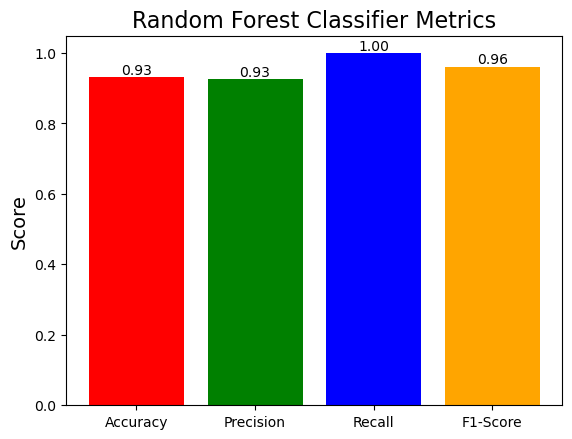

In [17]:
# Create feature vector with preprocessed text, get the metrics, and plot them using a bar graph
tfidf = TfidfVectorizer()
text = tfidf.fit_transform(df['review_text'])

X = text 
y = df['sentiment_label'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure()
bars = plt.bar(metrics, values, color=['red', 'green', 'blue', 'orange'])

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),f'{value:.2f}', ha='center', va='bottom')

plt.title("Random Forest Classifier Metrics", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0)
plt.show()


# Comparing Sentiment Rating to Steam Rating

In [15]:
# Create a new dataframe containing the app name, the non preprocessed review text, the original review score, and the predicted sentiment
original_text = pd.read_csv('projectData.csv') 

test_data = pd.DataFrame({'app_name': df.loc[y_test.index, 'app_name'],'review_text': original_data.loc[y_test.index, 'review_text'],  'review_score': df.loc[y_test.index, 'review_score'],'predicted_sentiment': y_pred.astype(int)})

review_score_differences = test_data[test_data['review_score'] != test_data['predicted_sentiment']]

same_review_scores = len(test_data[test_data['review_score'] == test_data['predicted_sentiment']])
differences_count = len(review_score_differences)

review_score_differences = review_score_differences[['app_name', 'review_score', 'predicted_sentiment', 'review_text']]

output_file = 'library_custompreprocessing.csv'
review_score_differences.to_csv(output_file, index=False)

print(f"Number of incorrectly scored reviews found: {differences_count}")
print(f"Number of correctly scored reviews found: {same_review_scores}")
print(f"Accuracy of predictions to original Steam review score: {same_review_scores / len(test_data) * 100:.2f}%")


Number of incorrectly scored reviews found: 138
Number of correctly scored reviews found: 864
Accuracy of predictions to original Steam review score: 86.23%
